In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = fetch_openml("credit-g", as_frame=True)
target = df.target
df.data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


1.1 Determine which features are continuous and which are categorical.

Based on the description of the data provided, foreign_worker, own_telephone, job, housing, other_payment_plans, property_magnitude, other_parites, personal_status, credit_history, num_dependents, and purpose are all categorical as these features consist of a finite number of distinct groups. In contrast, duration, credit_amount, age, 

In [3]:
continuous = ['age', 'credit_amount', 'duration', 'num_dependents', 
              'installment_commitment', 'residence_since', 'existing_credits']
categorical = [col for col in df.data.columns if col not in continuous]

In [4]:
# Unsure about these ones ...
existing_credits
residence_since
installment_commitment
num_dependents

NameError: name 'existing_credits' is not defined

1.2 Visualize the univariate distribution of each continuous feature, and the distribution of the
target

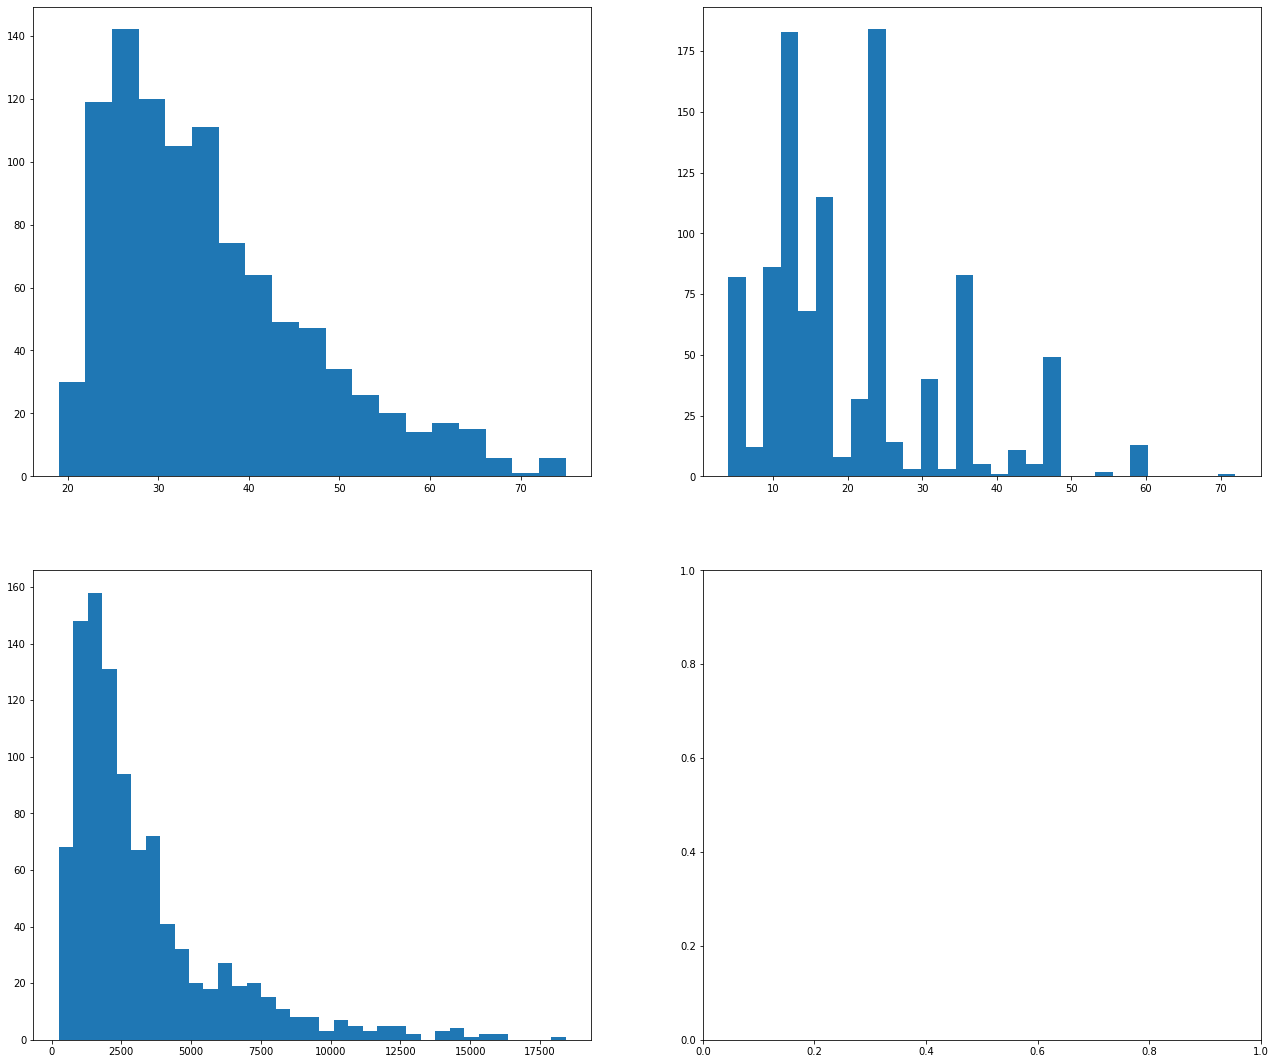

In [5]:
# Distribution of continuous variables
fig, ax = plt.subplots(2, 2, figsize=(22,19))
ax1, ax2, ax3, ax4 = ax.ravel()
ax1.hist(df.data['age'], bins='auto')
ax2.hist(df.data['duration'], bins='auto')
ax3.hist(df.data['credit_amount'], bins='auto')
plt.show()

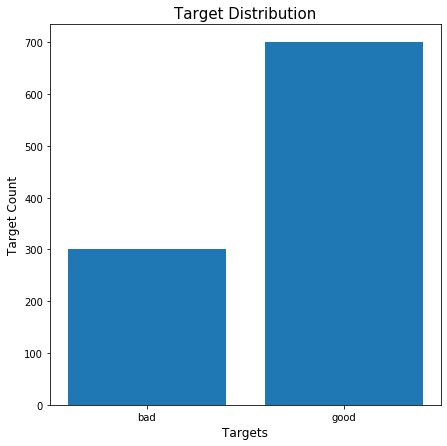

In [6]:
# Distribution of the target
target_names, target_nums = np.unique(target, return_counts=True)
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.bar(target_names, target_nums)
ax.set_xlabel('Targets', fontsize=12)
ax.set_ylabel('Target Count', fontsize=12)
ax.set_title('Target Distribution', fontsize=15)
plt.show()

1.3 Split data into training and test set. Do not use the test set until a final evaluation in 1.5.
Preprocess the data (such as treatment of categorical variables) without using a pipeline and
evaluate an initial LogisticRegression model with an training/validation split.

In [7]:
# Preprocessing: label encode target class
label_encoder = preprocessing.LabelEncoder()
encoded_target = label_encoder.fit_transform(target)

One-hot encode categorical variables

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df.data, encoded_target, stratify=encoded_target, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, shuffle=True)

In [10]:
X_train_ohe = pd.get_dummies(X_train, columns=categorical)
X_val_ohe = pd.get_dummies(X_val, columns=categorical) 

In [16]:
logis = LogisticRegression(max_iter=1000).fit(X_train_ohe, y_train)
logis.score(X_val_ohe, y_val)

0.7393617021276596

1.4 Use ColumnTransformer and pipeline to encode categorical variables (your choice of
OneHotEncoder or another one from the categorical_encoder package, or both). Evaluate
Logistic Regression, linear support vector machines and nearest neighbors using
cross-validation. How different are the results? How does scaling the continuous features with
StandardScaler influence the results?

In [12]:
to_encode = df.data.dtypes == 'category'
preprocess = make_column_transformer((preprocessing.OneHotEncoder(), to_encode))

In [13]:
logis_pipe = make_pipeline(preprocess, LogisticRegression())
logis_scores = cross_val_score(logis_pipe, X_train_val, y_train_val, cv=10)
np.mean(logis_scores)

0.7426666666666666

In [14]:
svm_pipe = make_pipeline(preprocess, LinearSVC())
svm_scores = cross_val_score(svm_pipe, X_train_val, y_train_val, cv=10)
np.mean(svm_scores)

0.7293333333333332

In [15]:
nn_pipe = make_pipeline(preprocess, KNeighborsClassifier())
nn_scores = cross_val_score(nn_pipe, X_train_val, y_train_val, cv=10)
np.mean(nn_scores)

0.7120000000000001

Add in standard scalar

In [22]:
preprocess_with_ss = make_column_transformer((preprocessing.StandardScaler(), ~to_encode),
                                     (preprocessing.OneHotEncoder(), to_encode))

In [23]:
logis_pipe = make_pipeline(preprocess_with_ss, LogisticRegression())
logis_scores = cross_val_score(logis_pipe, X_train_val, y_train_val, cv=10)
np.mean(logis_scores)

0.7413333333333334

In [26]:
svm_pipe = make_pipeline(preprocess_with_ss, LinearSVC())
svm_scores = cross_val_score(svm_pipe, X_train_val, y_train_val, cv=10)
np.mean(svm_scores)

/home/dipika/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/dipika/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/dipika/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/dipika/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/dipika/anaconda3/envs/applied_ml/lib/python3.8/sit

0.7386666666666667

In [25]:
nn_pipe = make_pipeline(preprocess_with_ss, KNeighborsClassifier())
nn_scores = cross_val_score(nn_pipe, X_train_val, y_train_val, cv=10)
np.mean(nn_scores)

0.7293333333333334

1.5 Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the best
model on the test set. Visualize the performance as function of the parameters for all three models.